## Notebook to determine ROIs for overlapping cells in 3d spot-based transcriptomics data

In [1]:
%load_ext autoreload
%autoreload 2


#### Basic imports:

In [2]:
import os
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import anndata

import ssam

#### Define parameters

In [3]:
# SSAM vector field resolution:
um_per_pixel = 3.0

# SSAM pandwidth:
bw = 1

# KNN diffusion iterations to move spots to z-axis zero mean:
z_centralization_iters = 20

# {0:'xenium_mouse_brain',1:'merfish_mouse_brain',2:'merfish_liver'}
dataset =0

file_root = '/dh-projects/ag-ishaque/analysis/tiesmeys/spot-data-z-axis-incoherence/src'


In [4]:
# Read data into memory using only the columns Gene_name, Centroid_X,Y,Z.




## Define & load data

####  0: Xenium Mouse brain dataset:

In [5]:

if dataset == 0:

    spot_df_raw = pd.read_csv('/dh-projects/ag-ishaque/analysis/tiesmeys/data/zenodo/MERFISH/raw_data/merfish_barcodes_example.csv', usecols=['Gene_name', 'Centroid_X', 'Centroid_Y', 'Centroid_Z'],)
    spot_df_raw.columns = ['gene','x','y','z']



    # Remove 'blank' genes:
    spot_df_raw = spot_df_raw[~spot_df_raw.gene.str.contains('Blank')][::1]

    spot_df_raw['gene']=spot_df_raw['gene'].astype('category')

    # spot_df = spot_df_raw.copy()
    genes = sorted(spot_df_raw.gene.unique())


spot_df_raw.x-=spot_df_raw.x.min()
spot_df_raw.y-=spot_df_raw.y.min()

spot_df_raw.x/=um_per_pixel
spot_df_raw.y/=um_per_pixel




In [6]:
from src import ovrlp

ovrlp.assign_xy(spot_df_raw)

gene           x          y    z  x_pixel  y_pixel  n_pixel
0        Krt90   24.293333  55.637667  0.0       24       55    32969
1        Krt90   25.141333   0.137000  0.0       25        0       25
2        Krt90   50.017000  56.798000  0.0       50       56    33594
3        Krt90   50.143667  33.991667  0.0       50       33    19817
4        Krt90   53.778333  53.882000  0.0       53       53    31800
...        ...         ...        ...  ...      ...      ...      ...
3739205  Ttyh2  525.898333  32.406000  9.0      525       32    19693
3739206  Ttyh2  528.576333  44.849000  9.0      528       44    26884
3739207  Ttyh2  529.754000  37.148000  9.0      529       37    22692
3739208  Ttyh2  530.754333  36.411000  9.0      530       36    22094
3739209  Ttyh2  532.218667  36.797000  9.0      532       36    22096

[3728169 rows x 7 columns]

In [7]:
mean = ovrlp.assign_z_mean(spot_df_raw)
 #spot_df_raw.z>((spot_df_raw.z.max()-spot_df_raw.z.min())/2)

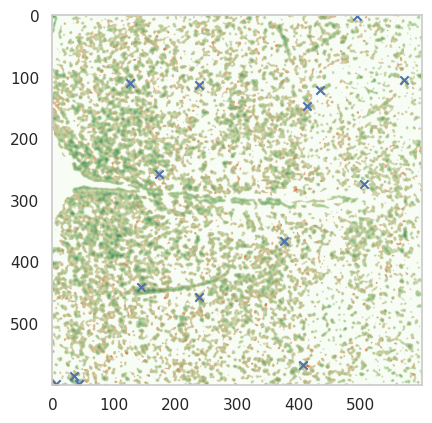

In [8]:

KDE_bandwidth = 1.5
min_expression = 10
min_distance = 10
threshold_fraction = 0.4

rois_x,rois_y,divergence_score = ovrlp.compute_divergence(spot_df_raw, genes=genes, 
                                                     KDE_bandwidth=KDE_bandwidth, threshold_fraction=threshold_fraction, 
                                                     min_distance = min_distance, min_expression=min_expression, plot=True)

In [34]:
expressions_top =  ovrlp.get_expression_vectors_at_rois(spot_df_raw[spot_df_raw.z>spot_df_raw.z_delim],
                                                        rois_x,rois_y,genes)

expressions_bottom =  ovrlp.get_expression_vectors_at_rois(spot_df_raw[spot_df_raw.z<spot_df_raw.z_delim],
                                                        rois_x,rois_y,genes)  
              
expressions = np.stack([expressions_top,expressions_bottom])


In [70]:
rois_x_ssam,rois_y_ssam = ovrlp.get_rois(spot_df_raw, genes = genes, min_distance=3,
                           KDE_bandwidth=KDE_bandwidth, min_expression=1)

localmax_celltyping_samples =  ovrlp.get_expression_vectors_at_rois(spot_df_raw,rois_x_ssam,rois_y_ssam,genes,) 

localmax_celltyping_samples = localmax_celltyping_samples/(localmax_celltyping_samples.to_numpy()**2).sum(0,keepdims=True)**0.5

# print(localmax_celltyping_samples.sum(1))


Ace2        12.787291
Adora2a     16.259801
Aldh1l1    253.835402
Amigo2     407.043249
Ano3        36.008970
              ...    
Tmem108    144.088529
Traf4       79.550835
Trhr        39.534747
Ttn         11.984028
Ttyh2      241.871185
Length: 135, dtype: float64


#### This cell contains helper functions from the UMAP2RGB package (alpha):

In [58]:
from sklearn.decomposition import PCA as Dimred


def fill_color_axes(rgb,dimred=None):

    if dimred is None:
        dimred = Dimred(n_components=3)
        dimred.fit(rgb)

    facs = dimred.transform(rgb)

    # rotate the ica_facs 45 in all the dimensions:
    # define a 45-degree 3d rotation matrix 
    # (0.500 | 0.500 | -0.707
    # -0.146 | 0.854 | 0.500
    # 0.854 | -0.146 | 0.500)
    rotation_matrix = np.array([[0.500,0.500,-0.707],
                                [-0.146,0.854,0.500],
                                [0.854,-0.146,0.500]])

    # rotate the facs:
    facs = np.dot(facs,rotation_matrix)


    return facs,dimred


# create circular kernel:
def create_circular_kernel(kernel_width):
    span = np.linspace(-1,1,kernel_width)
    X,Y = np.meshgrid(span,span)
    return (X**2+Y**2)**0.5<=1


# normalize array:
def min_to_max(arr):
    arr=arr-arr.min(0,keepdims=True)
    arr/=arr.max(0,keepdims=True)
    return arr

# convert cymk to rgb:
def cymk_to_rgb(cymk):
    c,y,m,k = cymk.T
    r = (1-c)*(1-k)
    g = (1-m)*(1-k)
    b = (1-y)*(1-k)
    return np.array([r,g,b]).T

def haversine_to_rgb(embedding):
    r = np.cos(embedding[:,0])*np.sin(embedding[:,1])
    g = np.sin(embedding[:,0])*np.sin(embedding[:,1])
    b = np.cos(embedding[:,1])
    return np.array([r,g,b]).T

def visualize_rgb_scale(rgb):
    fig = plt.figure(figsize=(15,7))

    ax1 = fig.add_subplot(121)
    ax1.scatter(embeddings_2d[:,0],embeddings_2d[:,1],c=rgb,alpha=0.5)
    plot_label_coords()

    ax2 = fig.add_subplot(122,projection='3d')
    ax2.scatter(rgb[:,0],rgb[:,1],rgb[:,2],c=rgb,alpha=0.5)

    plt.tight_layout()



(4084, 100)


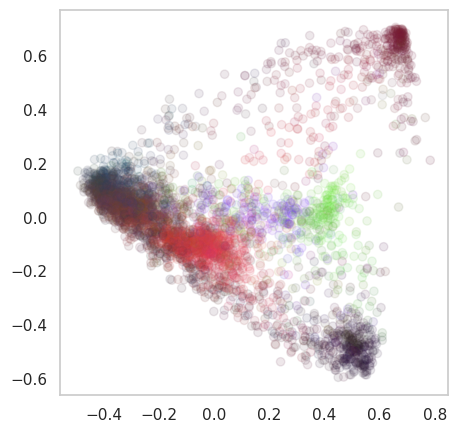

In [72]:
from sklearn.decomposition import PCA as dim_reduction

pca = dim_reduction(n_components=100)
factors = pca.fit_transform(localmax_celltyping_samples.T)

colors = min_to_max(factors[:,2:5])

plt.figure(figsize=(5,5))

plt.scatter(factors[:,0],factors[:,1],c=colors,alpha=0.1)



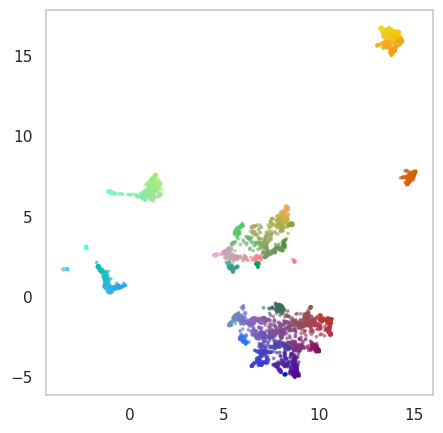

In [73]:
import umap

embedder_2d = umap.UMAP(n_components=2,min_dist=0.0)
embedding = embedder_2d.fit_transform(factors)

embedder_3d = umap.UMAP(n_components=3, min_dist=0.0,n_neighbors=10,
                  init=np.concatenate([embedding,0.1*np.random.normal(size=(embedding.shape[0],1))],axis=1))
embedding_color = embedder_3d.fit_transform(embedding)

embedding_color,color_pca = fill_color_axes(embedding_color)


color_min = embedding_color.min(0)
color_max = embedding_color.max(0)

colors = min_to_max(embedding_color.copy())

plt.figure(figsize=(5,5))
plt.scatter(embedding[:,0],embedding[:,1],c=colors,alpha=0.5,s=3)

In [ ]:
os.listdir(os.path.join(file_root,'../../data/zenodo/MERFISH/raw_data'))

['aau5324_moffitt_table-s1.csv',
 'cellboundaries_example_animal.csv',
 'merfish_barcodes_example.csv',
 '3.get_raw_data_from_ncbi.sh',
 'readme.txt',
 'GSE113576_genes.tsv.gz ',
 'GSE113576_barcodes.tsv.gz',
 'aau5324_Moffitt_Table-S1.xlsx',
 'GSE113576_matrix.mtx.gz',
 '2.get_raw_data_from_science.sh',
 'Moffitt_and_Bambah-Mukku_et_al_merfish_all_cells.csv',
 '1.get_raw_data_from_dryad.sh']

#### Load snRNAseq data for cell typing:

In [74]:
import gzip

scrna_genes = []

with gzip.open(os.path.join(file_root,"../../data/zenodo/MERFISH/raw_data/GSE113576_genes.tsv.gz "), "rt") as f:
    for line in f:
        ensid, gene = line.rstrip().split('\t')
        # Correct gene name
        if gene == '4732456N10Rik':
            gene = "Krt90"
        scrna_genes.append(gene)

scrna_barcodes = []
with gzip.open(os.path.join(file_root,"../../data/zenodo/MERFISH/raw_data/GSE113576_barcodes.tsv.gz"), "rt") as f:
    for line in f:
        scrna_barcodes.append(line.rstrip())

from scipy.io import mmread
with gzip.open(os.path.join(file_root,"../../data/zenodo/MERFISH/raw_data/GSE113576_matrix.mtx.gz")) as f:
    scrna_expmat = mmread(f)


In [75]:
import scanpy as sc
import anndata

adata_scrna = anndata.AnnData(X=scrna_expmat.T, obs={'barcode': scrna_barcodes}, var={'gene': scrna_genes})
adata_scrna.obs.index = adata_scrna.obs.index.astype(int)
adata_scrna

/tmp/ipykernel_1175860/3145855150.py:4: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_scrna = anndata.AnnData(X=scrna_expmat.T, obs={'barcode': scrna_barcodes}, var={'gene': scrna_genes})


AnnData object with n_obs × n_vars = 31299 × 27998
    obs: 'barcode'
    var: 'gene'

In [76]:
# Normalize adata_scrna with scanpy's experimental pearnson-residual minimizer:

# sc.experimental.pp.normalize_pearson_residuals(adata_scrna)
adata_scrna.X = np.array(np.nan_to_num(adata_scrna.X).todense()).squeeze()

In [77]:
scrna_cluster_dic = {}
scrna_cluster_dic2 = {}

# Downloaded from supp. material of Moffit et al, table S1
# This file contains cluster metadata
table_s1_df = pd.read_csv(os.path.join(file_root, 
            "../../data/zenodo/MERFISH/raw_data/aau5324_moffitt_table-s1.csv"), on_bad_lines='skip', )
table_s1_df = table_s1_df.fillna('')
adata_scrna.obs['cluster_1'] = ''
adata_scrna.obs['cluster_2'] = ''

n=0

for i, (bc, _, _, c1, c2, c3) in table_s1_df.iterrows():
    if c2 == '' and c3 == '':
        c2 = c1 # Ambiguous and Unstable
    elif c2 == '':
        c2 = c1 + ' (' + c3 + ')'
        
    adata_scrna.obs.loc[n,'cluster_1'] = c1
    adata_scrna.obs.loc[n,'cluster_2'] = c2
    
    scrna_cluster_dic[bc] = c1
    scrna_cluster_dic2[bc] = c2

    n+=1


In [78]:
celltypes = sorted(adata_scrna.obs.cluster_1.unique())
signatures = pd.DataFrame(index=genes,columns=celltypes)

# fill the signatures with mean expression values:
for celltype in signatures.columns:
    subset = adata_scrna.X[adata_scrna.obs.cluster_1==celltype]
    subset = pd.Series(np.nan_to_num(subset).mean(0),
                       index=adata_scrna.var.gene.values)

    signatures[celltype] = subset[genes].values / (subset.sum()+1)


#### create signature matrix:

#### assign celltypes to localmax samples:

In [80]:
# determine correlation of each localmax sample with the signatures:

def determine_celltype_class_assignments(expression_samples):
    correlations = np.array([np.corrcoef(expression_samples[i,:],signatures.values.T)[0,1:] for i in range(len(expression_samples))])
    return np.argmax(correlations,-1)

celltype_class_assignments = determine_celltype_class_assignments(localmax_celltyping_samples.to_numpy().T)

# determine the center of gravity of each celltype in the embedding:
celltype_centers = np.array([np.median(embedding[celltype_class_assignments==i,:],axis=0) for i in range(len(celltypes))])

/home/tiesmeys/miniconda3/envs/spatial2022/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tiesmeys/miniconda3/envs/spatial2022/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


#### plotting helper functions:

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


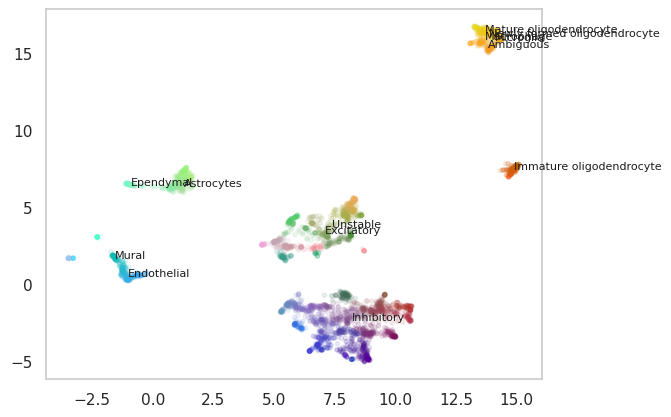

In [81]:
# define a function that fits expression data to into the umap embeddings:

def transform_embeddings(expression,pca):

    factors = pca.transform(expression)

    embedding = embedder_2d.transform(factors)
    embedding_color = embedder_3d.transform(embedding)
    
    # embedding_color = (embedding_color-color_min)/(color_max-color_min)
    
    return embedding, embedding_color

# define a function that plots the embeddings, with celltype centers rendered as plt.texts on top:
def plot_embeddings(embedding,embedding_color):
    colors = np.clip(embedding_color.copy(),0,1)

    plt.scatter(embedding[:,0],embedding[:,1],c=(colors),alpha=0.1,marker='.')
    for i in range(len(celltypes)):
        plt.text(celltype_centers[i,0],celltype_centers[i,1],celltypes[i],color='k',fontsize=8)


# plot embeddings, with celltype centers rendered as plt.texts on top:
plot_embeddings(embedding,colors)

In [83]:
from sklearn.neighbors import NearestNeighbors

# define a function that subsamples spots around x,y given a window size:
def get_spatial_subsample_mask(x,y,window_size=5):
    return (spot_df_raw.x>x-window_size)&(spot_df_raw.x<x+window_size)&(spot_df_raw.y>y-window_size)&(spot_df_raw.y<y+window_size)

# define a function that returns the k nearest neighbors of x,y:
def create_knn_graph(coords,k=10):
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(coords)
    distances, indices = nbrs.kneighbors(coords)
    return distances, indices

# get a kernel-weighted average of the expression values of the k nearest neighbors of x,y:
def get_knn_expression(distances,neighbor_indices,gene_labels,bandwidth=2.5):

    weights = np.exp(-distances/bandwidth)
    local_expression = pd.DataFrame(index = genes, columns = np.arange(distances.shape[0])).astype(float)

    for i,gene in enumerate(genes):
        weights_ = weights.copy()
        weights_[(gene_labels[neighbor_indices])!=i] = 0
        local_expression.loc[gene,:] = weights_.sum(1)
    
    return local_expression

def pixelmap_to_raw(x,y):
    shift_x = int((spot_df_raw.x/um_per_pixel).min())
    shift_y = int((spot_df_raw.y/um_per_pixel).min())
    return (x+shift_x)*um_per_pixel,(y+shift_y)*um_per_pixel

def raw_to_pixelmap(x,y):
    x = ((spot_df_raw.x/um_per_pixel).astype(int))
    y = ((spot_df_raw.y/um_per_pixel).astype(int))

    return (x/um_per_pixel-x.min()),(y/um_per_pixel-y.min())

KeyboardInterrupt: 

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


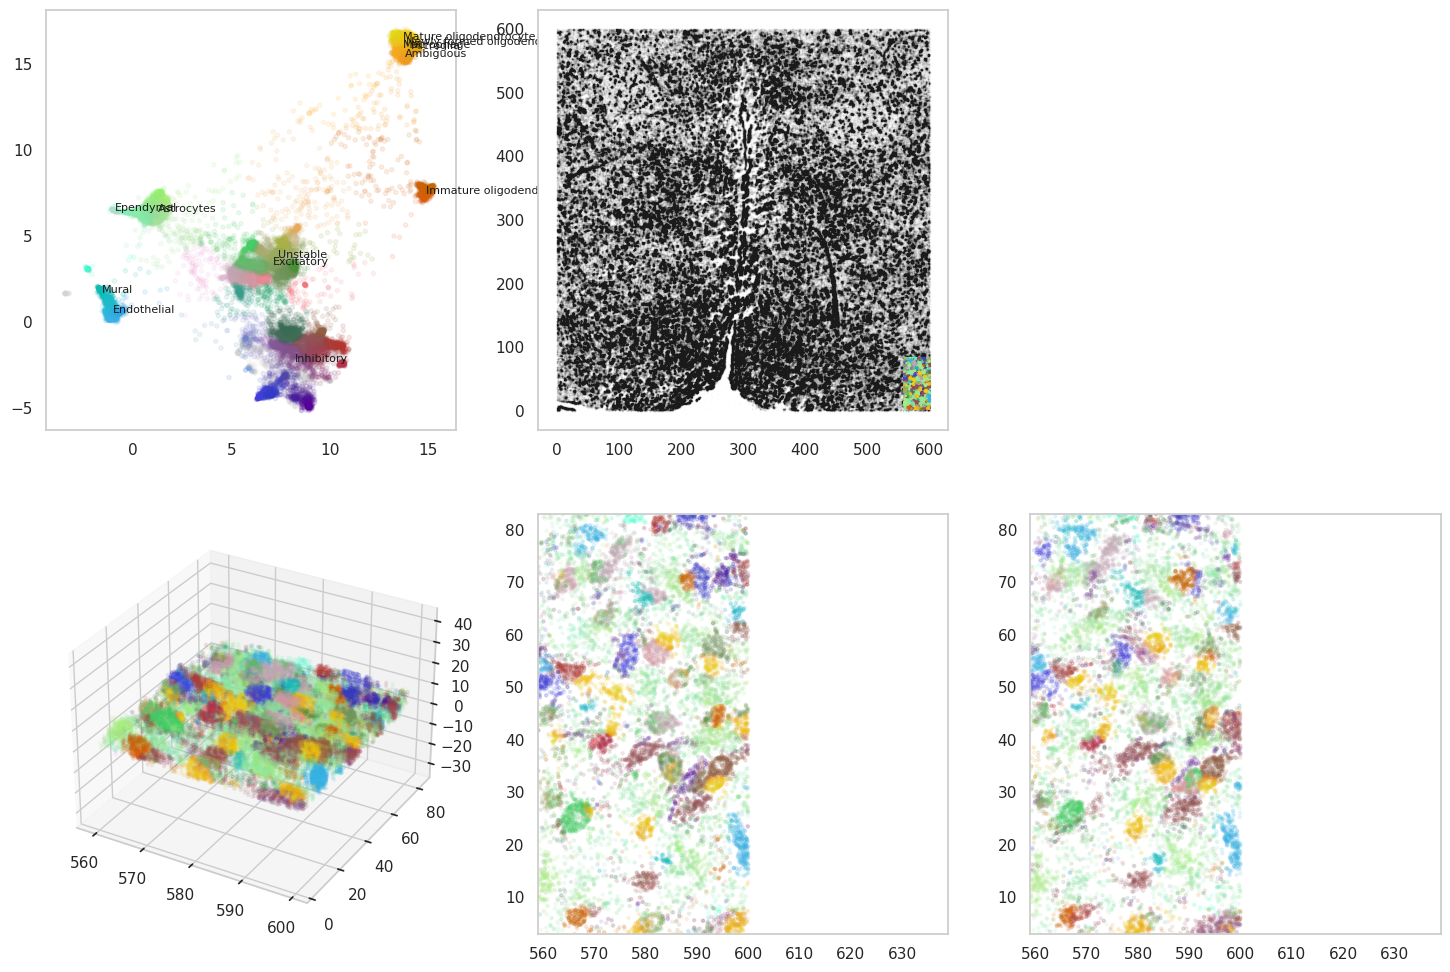

posx and posy should be finite values
posx and posy should be finite values


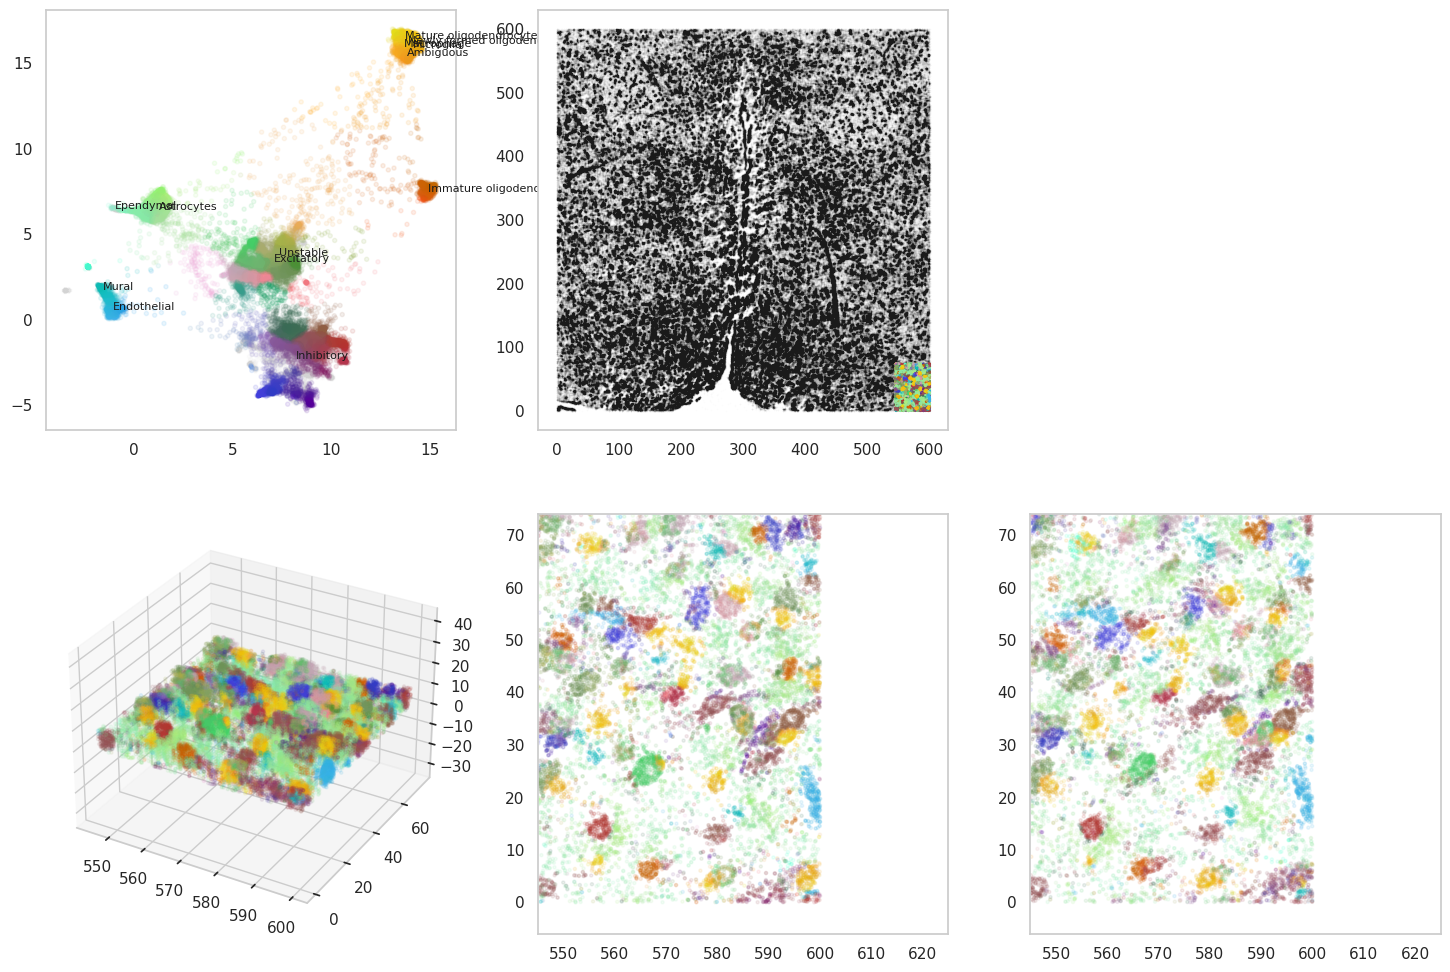

posx and posy should be finite values
posx and posy should be finite values


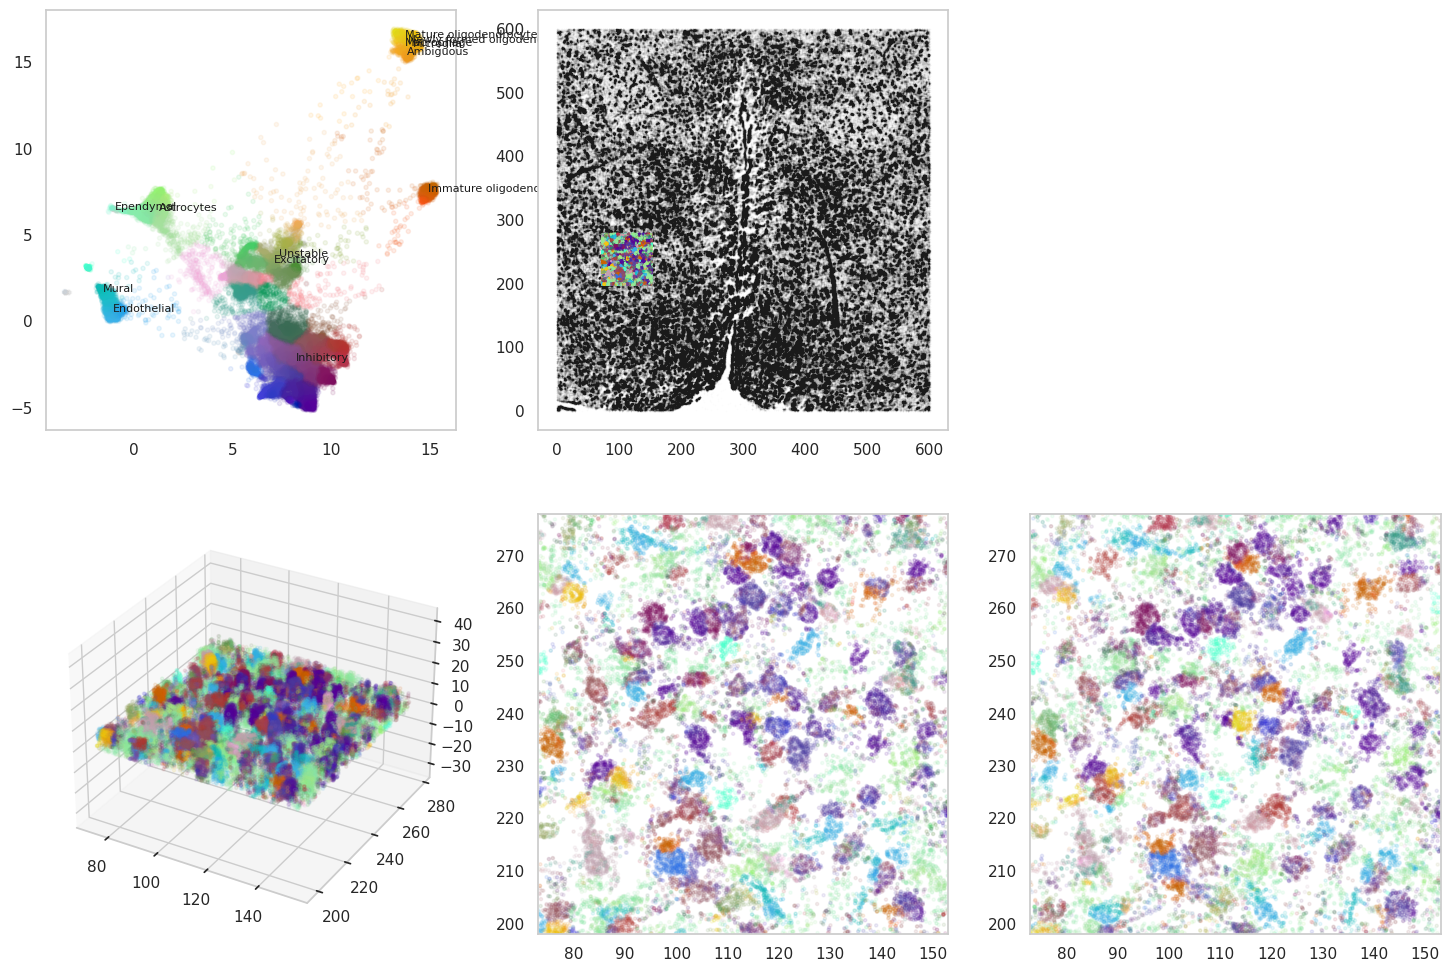

posx and posy should be finite values
posx and posy should be finite values


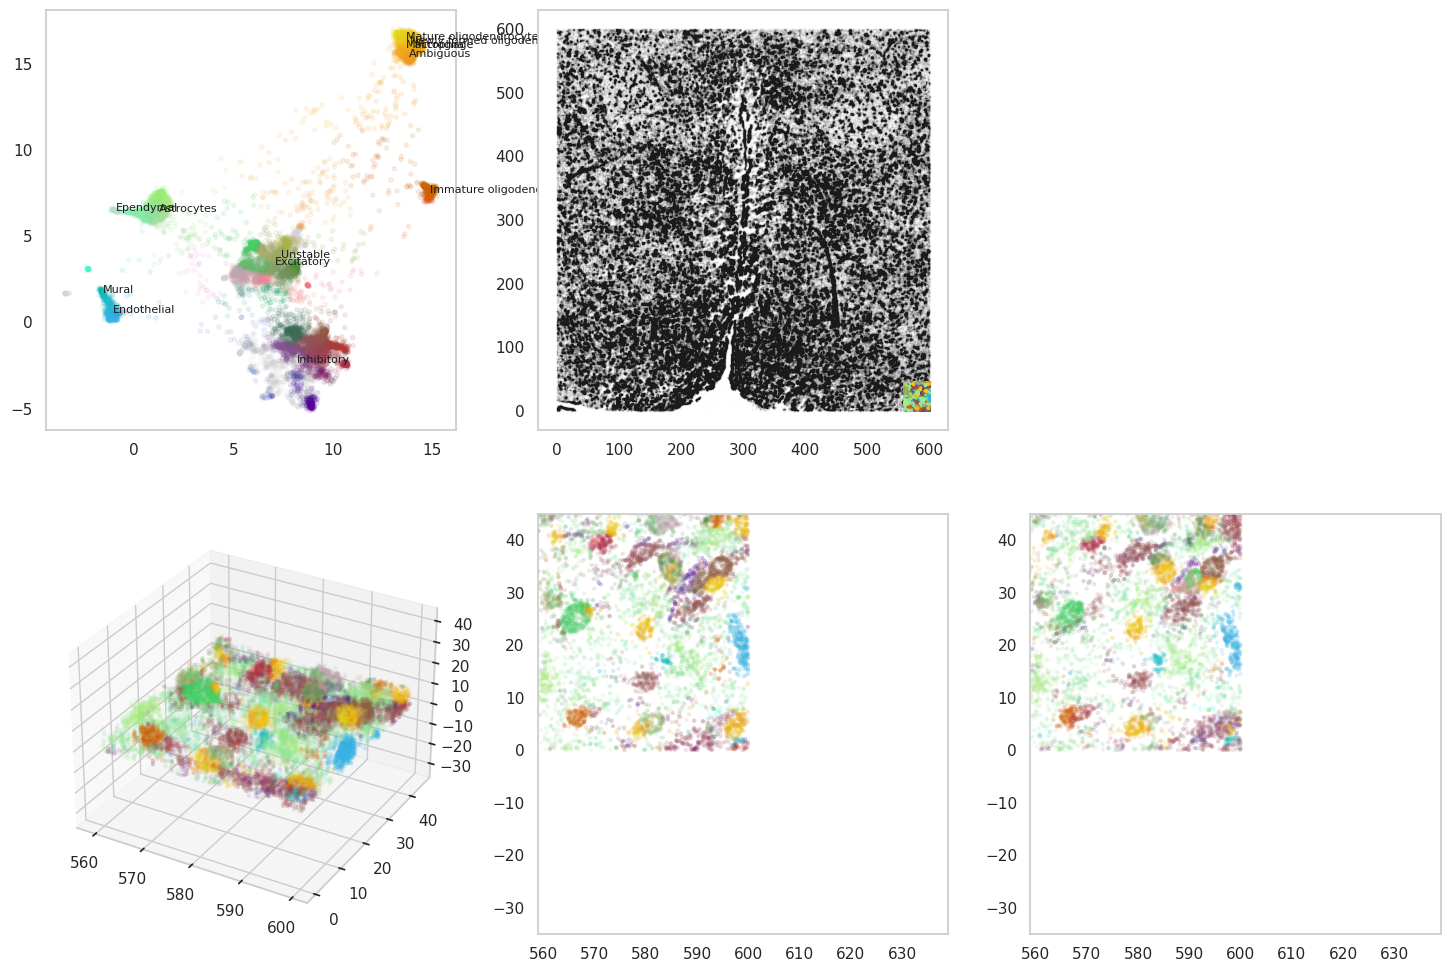

posx and posy should be finite values
posx and posy should be finite values


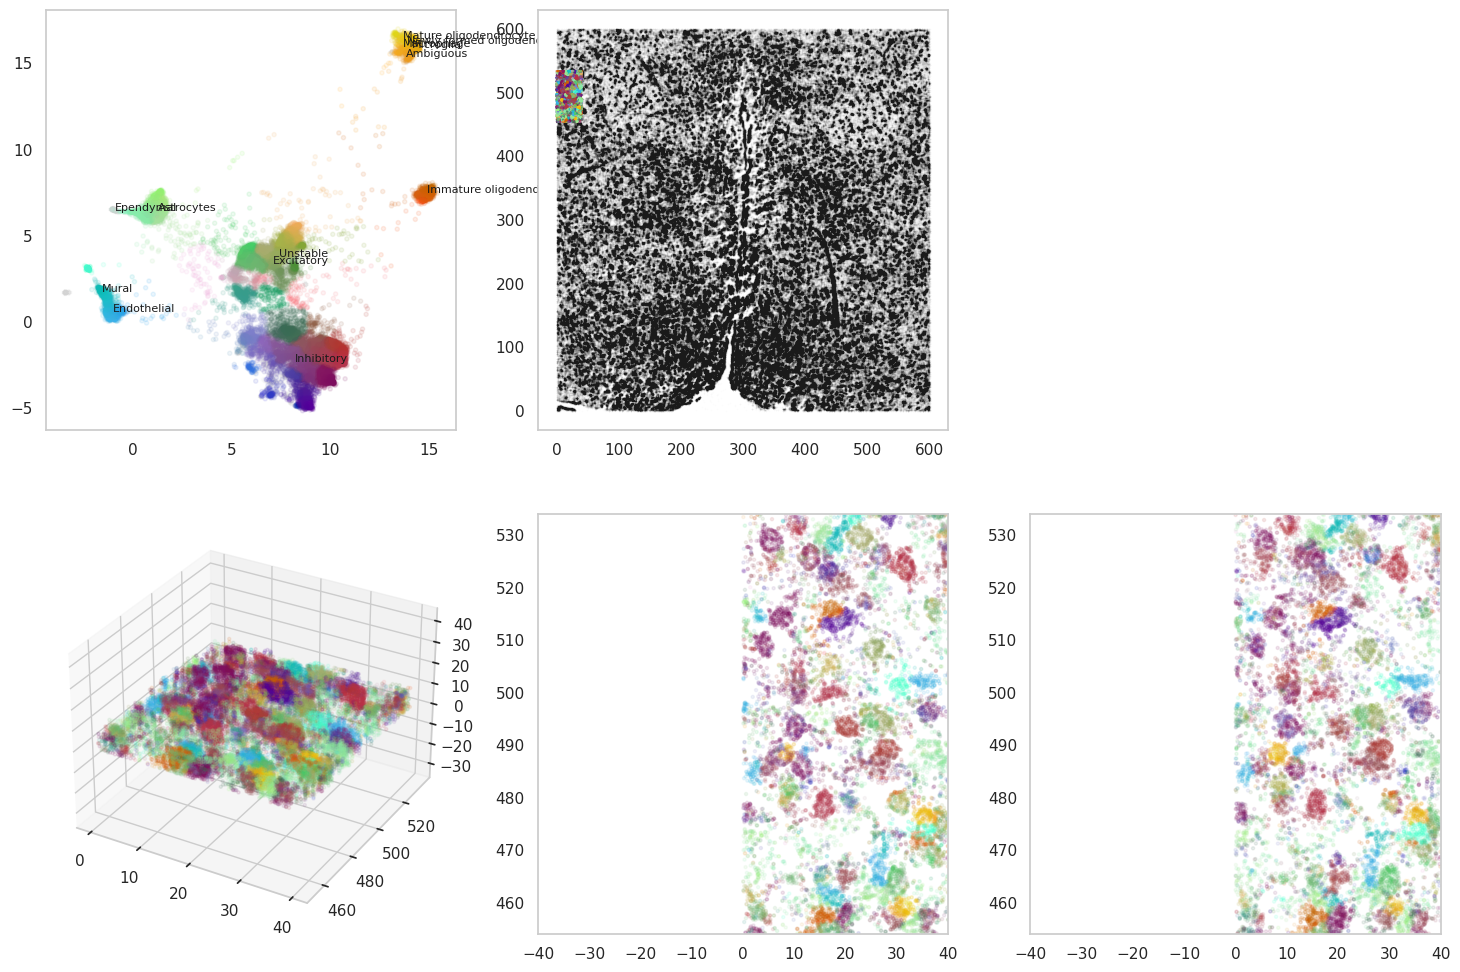

posx and posy should be finite values
posx and posy should be finite values


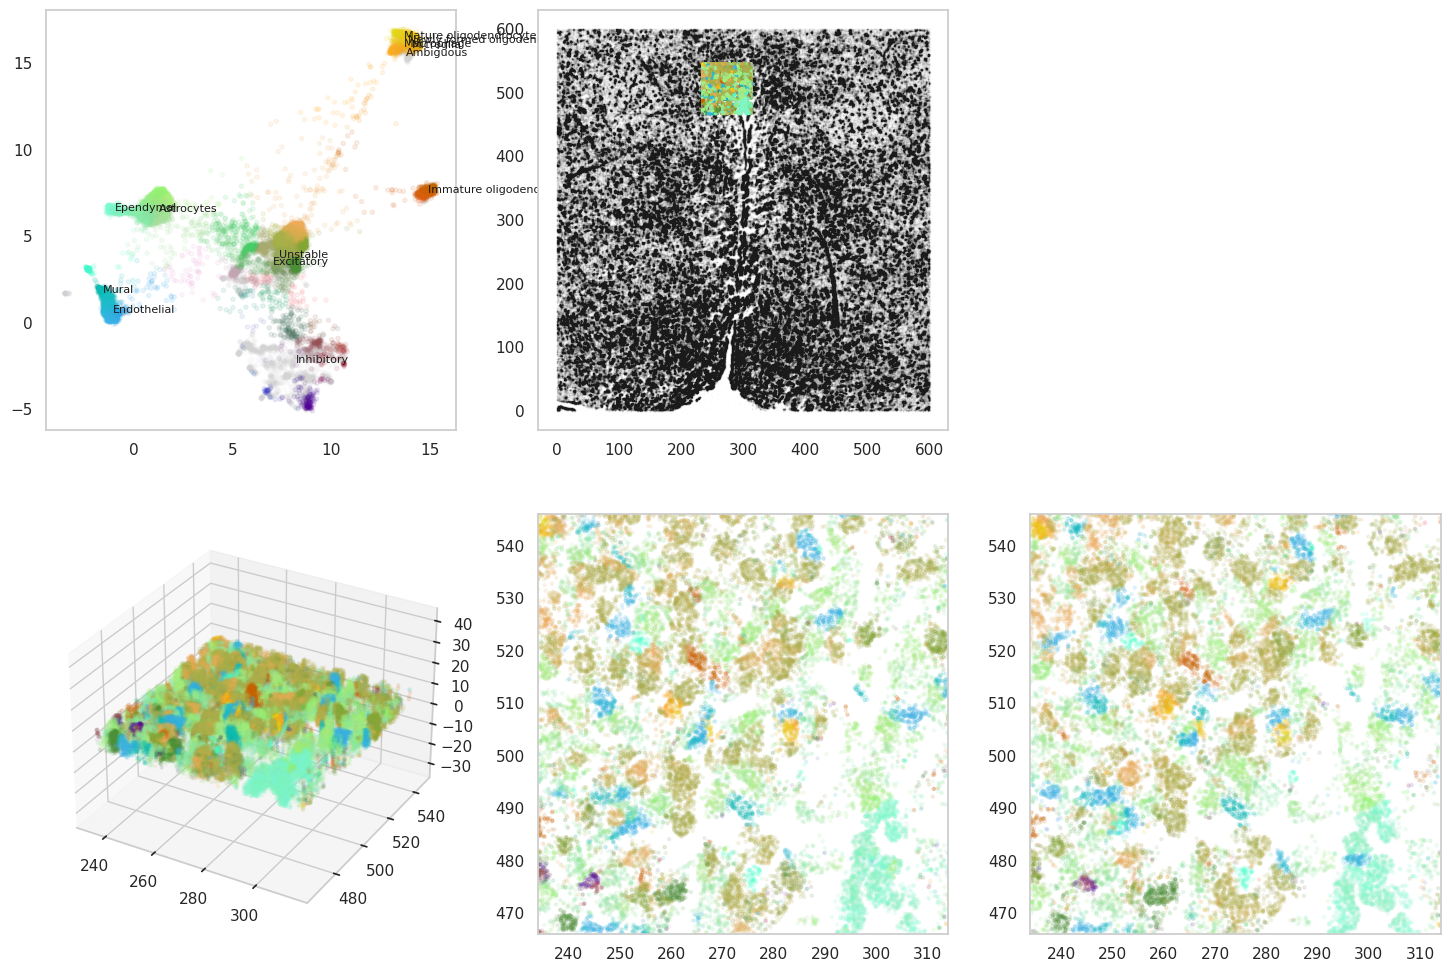

In [85]:
# plot a case of z-incoherence:

# sorted_correlations = correlation.argsort()
correlation = np.array(divergence_score)
idcs = correlation.argsort()[::-1] #sorted_correlations.values[[0]]


def plot_z_incoherence(n_case,window_size = 30):
        
    x,y = (rois_x[idcs[n_case]],rois_y[idcs[n_case]])

    # ct_top,ct_bottom = get_celltype(expressions_top.iloc[idcs[n_case]]),get_celltype(expressions_bottom.iloc[idcs[n_case]])

    subsample_mask = get_spatial_subsample_mask(x,y,window_size=window_size)
    subsample = spot_df_raw[subsample_mask]

    distances, neighbor_indices = create_knn_graph(subsample[['x','y','z']].values,k=90)
    local_expression = get_knn_expression(distances,neighbor_indices,subsample.gene.cat.codes.values,bandwidth=1.0)
    local_expression = local_expression/((local_expression**2).sum(0)**0.5)
    subsample_embedding, subsample_embedding_color = transform_embeddings(local_expression.T.values,pca)
    subsample_embedding_color,_ = fill_color_axes(subsample_embedding_color,color_pca)
    subsample_embedding_color = (subsample_embedding_color-color_min)/(color_max-color_min)
    subsample_embedding_color = np.clip(subsample_embedding_color,0,1)

    plt.figure(figsize=(18,12))

    # plt.suptitle('-'.join([str(ct_top),str(ct_bottom)]))

    ax1 = plt.subplot(234,projection='3d')
    ax1.scatter(subsample.x,subsample.y,subsample.z,c=subsample_embedding_color,marker='.',alpha=0.1)
    ax1.set_zlim(np.median(subsample.z)-window_size,np.median(subsample.z)+window_size)

    ax2 = plt.subplot(231)
    plt.scatter(embedding[:,0],embedding[:,1],c='lightgrey',alpha=0.05,marker='.')
    plot_embeddings(subsample_embedding,subsample_embedding_color)
    # plt.scatter(subsample_embedding[:,0],subsample_embedding[:,1],c=subsample_embedding_color,marker='.',alpha=0.1,s=10)

    # ax3 = plt.subplot(235)
    # central_cutout = subsample[(subsample.x<x+5)&(subsample.x>x-5)]
    # ax3.scatter(central_cutout.y,central_cutout.z,c=subsample_embedding_color[(subsample.x<x+5)&(subsample.x>x-5)])
    # ax3.set_ylim(np.median(subsample.z)-window_size/2,np.median(subsample.z)+window_size/2)

    # ax3 = plt.subplot(236)
    # central_cutout = subsample[(subsample.y<y+5)&(subsample.y>y-5)]
    # ax3.scatter(central_cutout.x,central_cutout.z,c=subsample_embedding_color[(subsample.y<y+5)&(subsample.y>y-5)])
    # ax3.set_ylim(np.median(subsample.z)-window_size/2,np.median(subsample.z)+window_size/2)
    
    ax3 = plt.subplot(235)
    # plt.imshow((divergence*hist_sum).T,cmap='Greys', alpha=0.3 )
    ax3.scatter(subsample[subsample.z>subsample.z_delim].x,subsample[subsample.z>subsample.z_delim].y,
    c=subsample_embedding_color[subsample.z>subsample.z_delim],marker='.',alpha=0.1,s=20)
    ax3.set_xlim(x-window_size,x+window_size)
    ax3.set_ylim(y-window_size,y+window_size)

    ax3 = plt.subplot(236)    
    # plt.imshow(hist_sum.T,cmap='Greys',alpha=0.3 )
    ax3.scatter(subsample[subsample.z<subsample.z_delim].x,subsample[subsample.z<subsample.z_delim].y,
    c=subsample_embedding_color[subsample.z<subsample.z_delim],marker='.',alpha=0.1,s=20)
    ax3.set_xlim(x-window_size,x+window_size)
    ax3.set_ylim(y-window_size,y+window_size)
    # ax3.set_ylim(np.median(subsample.z)-window_size/2,np.median(subsample.z)+window_size/2)

    # ax3 = plt.subplot(236)
    # central_cutout = subsample[(subsample.y<y+5)&(subsample.y>y-5)]
    # ax3.scatter(central_cutout.x,central_cutout.z,c=subsample_embedding_color[(subsample.y<y+5)&(subsample.y>y-5)])
    # ax3.set_ylim(np.median(subsample.z)-window_size/2,np.median(subsample.z)+window_size/2)

    ax4 = plt.subplot(232)
    plt.scatter(spot_df_raw.x,spot_df_raw.y,c='k',alpha=0.01,marker='.',s=1)
    plt.scatter(subsample.x,subsample.y,c=subsample_embedding_color,marker='.',alpha=0.8,s=1)

    # ax5 = plt.subplot(233)
    # s_expression = pd.Series(expressions_top.iloc[idcs[n_case]]-expressions_bottom.iloc[idcs[n_case]],index=genes)
    # idcs_ = (s_expression**2).argsort()[:-20:-1]
    # expressions_top.iloc[idcs[n_case]].iloc[idcs_].plot.bar()
    # (-expressions_bottom).iloc[idcs[n_case]].iloc[idcs_].plot.bar(color='r')


    # ax4 = plt.subplot(224)
    # plt.scatter(subsample.x,subsample.y,c=subsample_embedding_color,marker='.',alpha=0.8,s=20)


for i in range(10):
    plot_z_incoherence(i)

In [ ]:
color_max

array([12.87672231, 16.21493319, 14.03950031])

In [87]:
i

6